<a href="https://colab.research.google.com/github/Brilleslangen/generative-adverserial-network/blob/main/GAN/execute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Concolutional Generative Adverserial Network

## Discriminator

In [ ]:
import torch.nn as nn
from traitlets.config.application import OrderedDict


class Discriminator(nn.Module):
    def __init__(self, fm_size, channels, num_channels):
        super().__init__()
        modules = OrderedDict()

        # Layer 1: Convolution with leaky ReLU
        modules['L1-conv'] = nn.Conv2d(
            in_channels=channels, 
            out_channels=fm_size, 
            kernel_size=4,
            stride=2, 
            padding=1, 
            bias=False)
        modules['L1-norm'] = nn.BatchNorm2d(fm_size)
        modules['L1-leaky-relu'] = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
        for i in range(2, num_channels+2):
            modules[f'L{i}-conv'] = nn.Conv2d(
                in_channels=fm_size * 2 ** (i-2),
                out_channels=fm_size * 2 ** (i-1),
                kernel_size=4,
                stride=2,
                padding=1
            )
            modules[f'L{i}-norm'] = nn.BatchNorm2d(fm_size * 2 ** (i-1))
            modules[f'L{i}-leaky-relu'] = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # Final convolution layer with sigmoid
        modules[f'L{num_channels+2}-conv'] = nn.Conv2d(
            in_channels=fm_size * 2 ** num_channels,
            out_channels=1,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
        )
        modules[f'L{num_channels+2}-sigmoid'] = nn.Sigmoid()

        self.model = nn.Sequential(modules)

    def forward(self, input):
        return self.model(input)


## Generator

In [ ]:
import torch.nn as nn
from traitlets.config.application import OrderedDict


class Generator(nn.Module):
    def __init__(self, latent_space_size, image_size, num_image_chan, num_conv_layers):
        super().__init__()
        modules = OrderedDict()

        # Initialize number of filters for each layer
        feature_map_sizes = [image_size * 2 ** (i + 1) for i in range(num_conv_layers, -1, -1)]
        print(feature_map_sizes)

        # Initialize Latent Vector Space
        modules['LS-conv'] = nn.ConvTranspose2d(
            in_channels=latent_space_size,
            out_channels=feature_map_sizes[0],
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False)
        modules['LS-norm'] = nn.BatchNorm2d(feature_map_sizes[0])
        modules['LS-relu'] = nn.ReLU(True)

        # Apply Transposed Convolution for each Conv-module
        for i in range(len(feature_map_sizes) - 1):
            print(f"in: {feature_map_sizes[i]}, out: {feature_map_sizes[i + 1]}")
            modules[f'L{i}-conv'] = nn.ConvTranspose2d(
                in_channels=feature_map_sizes[i],
                out_channels=feature_map_sizes[i + 1],
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
            modules[f'L{i}-norm'] = nn.BatchNorm2d(feature_map_sizes[i + 1])
            modules[f'L{i}-relu'] = nn.ReLU(True)

        # Generate output image
        modules['Output'] = nn.ConvTranspose2d(
            in_channels=feature_map_sizes[-1],
            out_channels=num_image_chan,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False)
        modules['Output-activation'] = nn.Tanh()

        # Add modules to model
        self.model = nn.Sequential(modules)

    def forward(self, x):
        return self.model(x)


## GAN

In [ ]:
import sys
import numpy as np
import torchvision.utils as tvutils
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


def weights_init(model):
    classname = model.__class__.__name__

    if classname.find("Conv") != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)


def display_images(images):
    fig = plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(tvutils.make_grid(images[:32], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()
    plt.close(fig)


class Gan:
    def __init__(self, generator, discriminator, dataloader, batch_size=32, latent_space_size=100):
        # Decide which device we want to run on
        device = "cuda" if torch.cuda.is_available() else "cpu"
        device = torch.device(device)

        # Initiate
        self.device = device
        self.generator = generator.apply(weights_init).to(device=self.device)
        self.discriminator = discriminator.apply(weights_init).to(device=self.device)
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.latent_space_size = latent_space_size

    def init_train_conditions(self):
        # Hyper parameters
        lr = 0.0002
        epochs = 20
        episodes = len(self.dataloader)

        # Loss functions and optimizers
        loss = torch.nn.BCELoss().to(self.device)
        disc_optim = torch.optim.Adam(self.discriminator.parameters(), lr=lr,
                                      betas=(0.5, 0.999), weight_decay=0.0002 / epochs)
        gen_optim = torch.optim.Adam(self.generator.parameters(), lr=lr,
                                     betas=(0.5, 0.999), weight_decay=0.0002 / epochs)

        # Training variables
        benchmark_seed = torch.randn(256, 100, 1, 1, device=self.device)
        real = 1
        fake = 0

        print(f'episodes: {episodes}')

        return lr, epochs, episodes, loss, disc_optim, gen_optim, benchmark_seed, real, fake

    def train(self):
        # Initiate Training Conditions
        lr, epochs, episodes, loss, disc_optim, gen_optim, noise_seed, real, fake = self.init_train_conditions()

        # Training
        for epoch in range(epochs):

            gen_loss = 0
            disc_loss = 0

            for i, batch in enumerate(self.dataloader):
                # Get batch of real images
                self.discriminator.zero_grad()
                real_samples = batch[0].to(self.device)
                sample_size = len(real_samples)

                # Create real and fake labels
                real_labels = torch.full((sample_size,), real, dtype=torch.float, device=self.device)
                fake_labels = torch.full((sample_size,), fake, dtype=torch.float, device=self.device)

                # Discriminate real samples and calculate loss
                pred_real = self.discriminator(real_samples).view(-1)
                error_real = loss(pred_real, real_labels)
                error_real.backward()

                # Discriminate fake samples and calculate loss
                latent_vector = torch.randn(sample_size, self.latent_space_size, 1, 1, device=self.device)
                fake_samples = self.generator(latent_vector)

                pred_fake = self.discriminator(fake_samples.detach()).view(-1)
                error_fake = loss(pred_fake, fake_labels)
                error_fake.backward()

                # Calculate total discriminator loss
                disc_batch_loss = error_real + error_fake
                disc_optim.step()

                # Generate fake samples and calculate loss
                self.generator.zero_grad()
                pred_fake = self.discriminator(fake_samples).view(-1)

                gen_batch_loss = loss(pred_fake, real_labels)
                gen_batch_loss.backward()

                gen_optim.step()

                gen_loss += gen_batch_loss
                disc_loss += disc_batch_loss

                if i % (round(episodes / 100)) == 0:
                    sys.stdout.write(f'\rEpoch {epoch + 1}: {((i + 1) * 100) // episodes}%')

            print(f'\n - Generator loss: {gen_loss / episodes},'
                  f' Discriminator loss: {disc_loss / episodes}')

            # Print image every other epoch
            self.generator.eval()
            images = self.generator(noise_seed)
            display_images(images)
            self.generator.train()                 



### Download dataset
Uncomment section below to download.
To download the dataset you will need a kaggle API Token

1. Create a Kaggle user
2. Go to account settings -> Create New API Token
3. A "Kaggle.json" file will be saved to your computer

When you run the code cell below, it will display a button "choose file". Click it and select the "kaggle.json"-file. The dataset will then be downloaded.

In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload() # Select the kaggle.json file

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download 'bryanb/abstract-art-gallery' -p /content/sample_data/ --unzip

Saving kaggle.json to kaggle.json
 97% 675M/693M [00:05<00:00, 152MB/s]
100% 693M/693M [00:05<00:00, 125MB/s]


### Imports and load dataset
The dataset contains 2879 pictures of abstract art *😮‍💨😮‍💨*

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



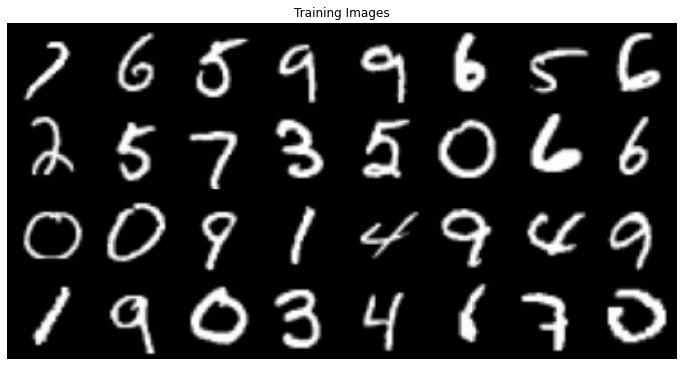

In [ ]:
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import DataLoader

# Latent vector size
ls_size = 100

# Batch size
batch_size = 32

# Feature map size for generator and discriminator
fm_size = 64

# Number of channels in image
num_img_chan = 3

# Amount of Convolutional layers
num_layers = 3

# Load data
datasets = ['mnist', 'abstract-art']
set_type = datasets[0]
dataset = ""

if set_type == datasets[0]:
    transform = transforms.Compose([transforms.Resize(fm_size), transforms.CenterCrop(fm_size),
                                    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    dataset = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
    num_img_chan = 1

elif set_type == datasets[1]:
    transform = transforms.Compose([transforms.Resize(fm_size), transforms.CenterCrop(fm_size),
                                    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])
    dataset = ImageFolder(root="./sample_data/Abstract_gallery", transform=transform)
    num_img_chan = 3

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set batch
real_batch = next(iter(dataloader))

# Display images
display_images(real_batch[0])

## Execute

[1024, 512, 256, 128]
in: 1024, out: 512
in: 512, out: 256
in: 256, out: 128
episodes: 1875
Epoch 1: 99%
 - Generator loss: 5.25622034072876, Discriminator loss: 0.6128759980201721


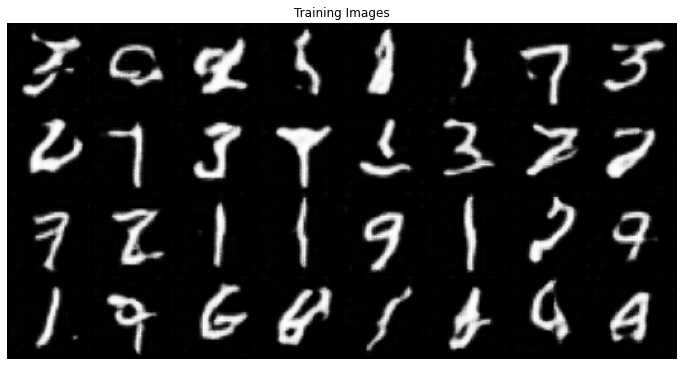

Epoch 2: 99%
 - Generator loss: 3.5995514392852783, Discriminator loss: 0.5102664232254028


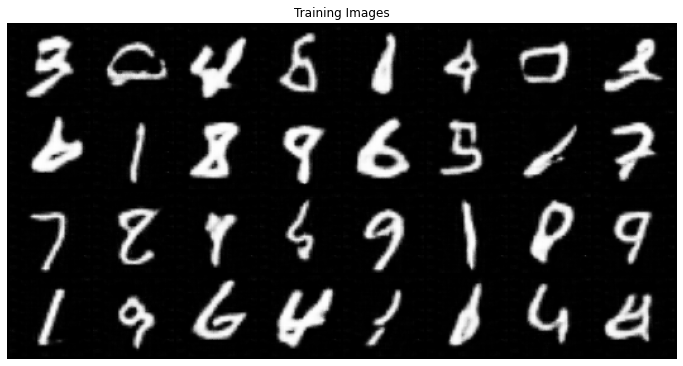

Epoch 3: 99%
 - Generator loss: 3.7236480712890625, Discriminator loss: 0.4867716133594513


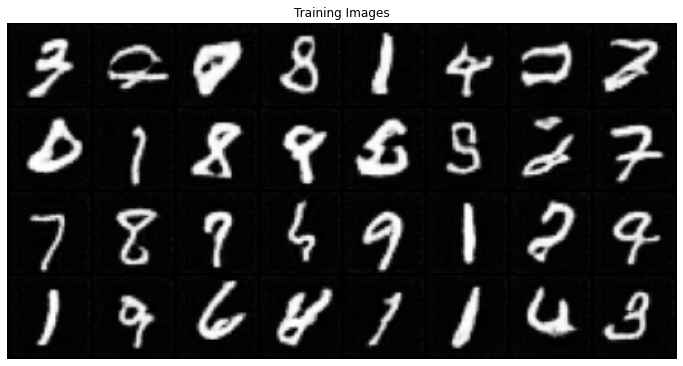

Epoch 4: 99%
 - Generator loss: 4.0026726722717285, Discriminator loss: 0.4121590852737427


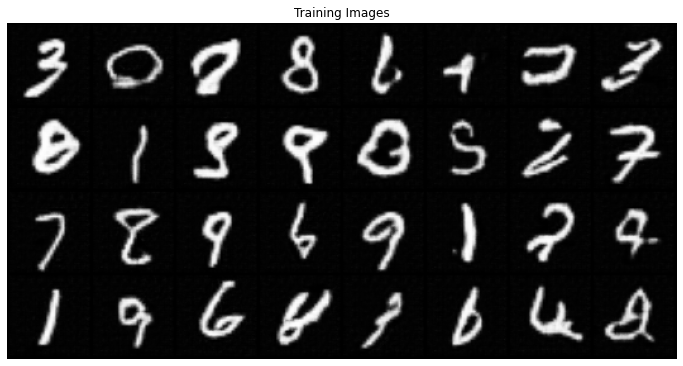

Epoch 5: 99%
 - Generator loss: 4.257437705993652, Discriminator loss: 0.3579361140727997


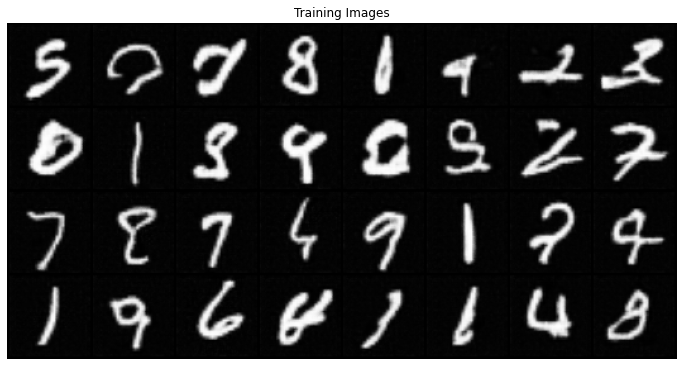

Epoch 6: 99%
 - Generator loss: 4.491125583648682, Discriminator loss: 0.3420225977897644


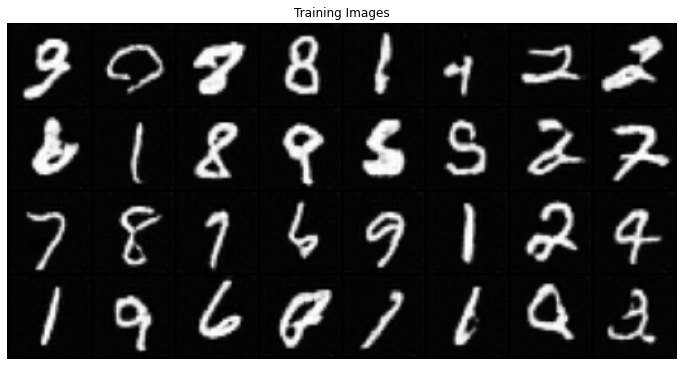

Epoch 7: 99%
 - Generator loss: 4.48128604888916, Discriminator loss: 0.35010841488838196


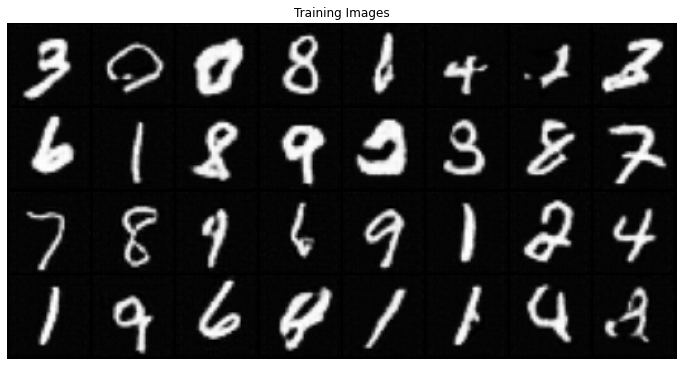

Epoch 8: 99%
 - Generator loss: 4.7341694831848145, Discriminator loss: 0.30844375491142273


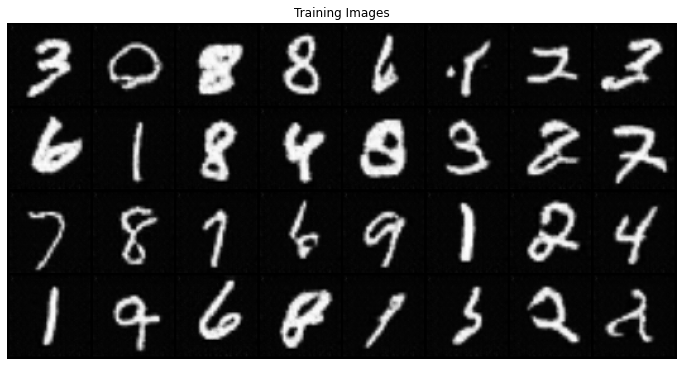

Epoch 9: 99%
 - Generator loss: 41.231300354003906, Discriminator loss: 0.018861347809433937


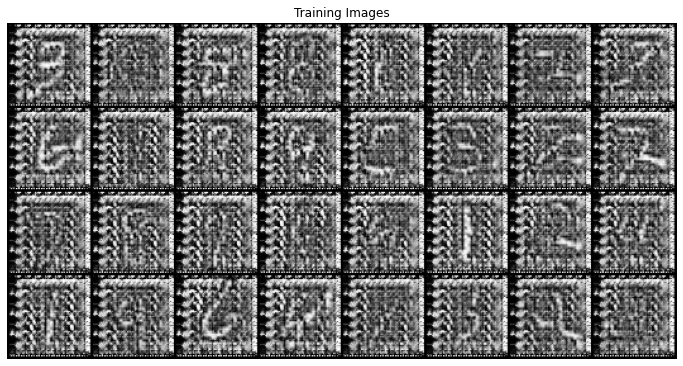

Epoch 10: 99%
 - Generator loss: 45.57725143432617, Discriminator loss: 2.709018417590414e-06


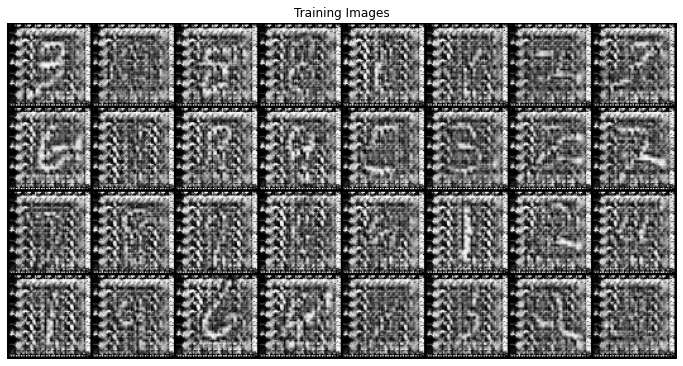

Epoch 11: 99%
 - Generator loss: 45.18960189819336, Discriminator loss: 7.741301146779733e-07


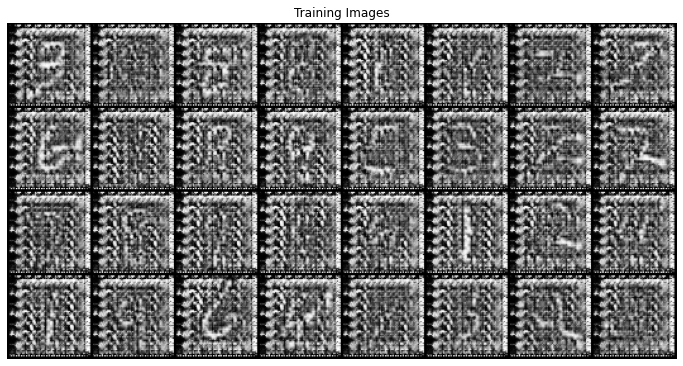

Epoch 12: 99%
 - Generator loss: 44.65576171875, Discriminator loss: 2.8245236194379686e-07


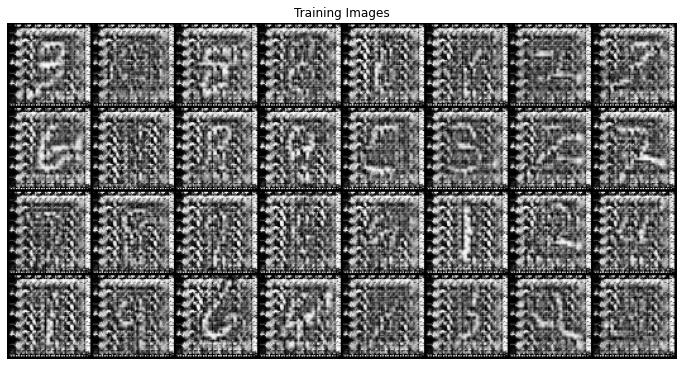

Epoch 13: 99%
 - Generator loss: 45.217220306396484, Discriminator loss: 0.01231048721820116


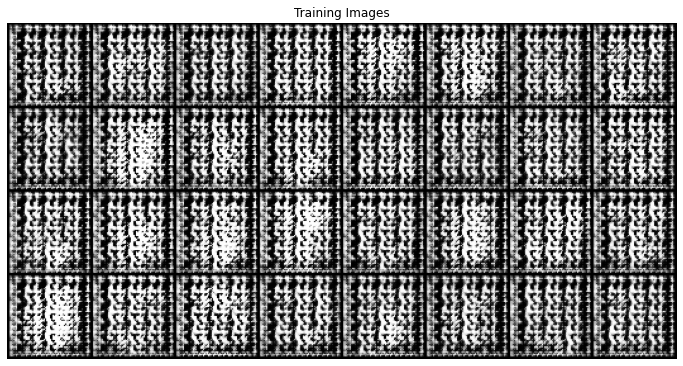

Epoch 14: 99%
 - Generator loss: 36.191314697265625, Discriminator loss: 0.38517850637435913


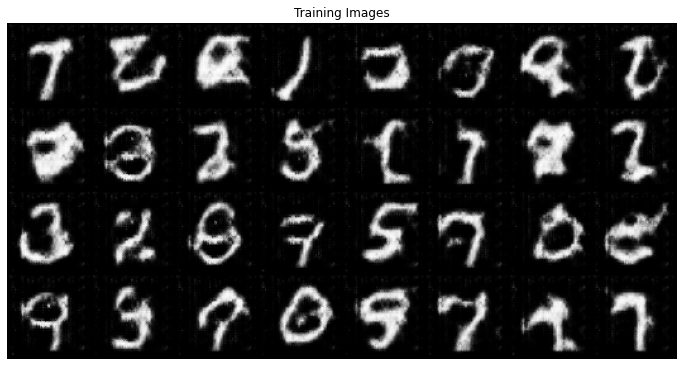

Epoch 15: 99%
 - Generator loss: 5.011041641235352, Discriminator loss: 0.19439497590065002


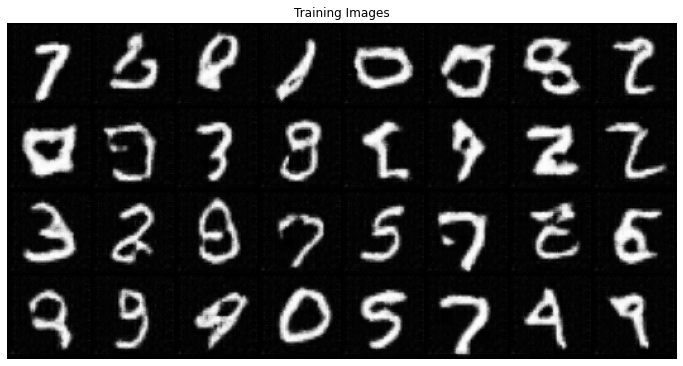

Epoch 16: 99%
 - Generator loss: 5.473056316375732, Discriminator loss: 0.1528094857931137


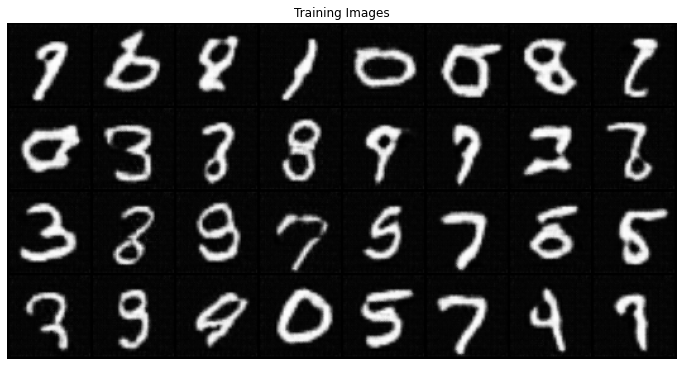

Epoch 17: 99%
 - Generator loss: 6.96543550491333, Discriminator loss: 0.11078668385744095


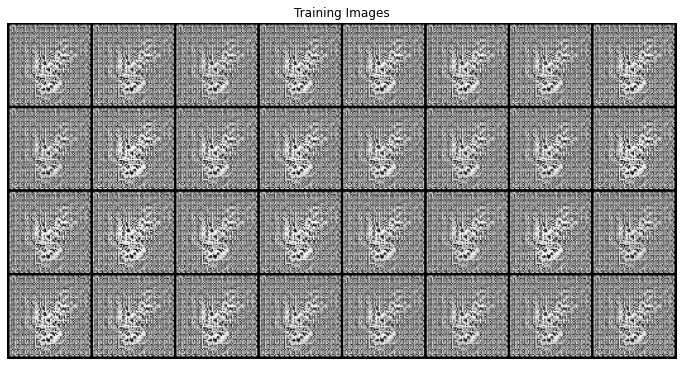

Epoch 18: 99%
 - Generator loss: 10.194767951965332, Discriminator loss: 0.00020879178191535175


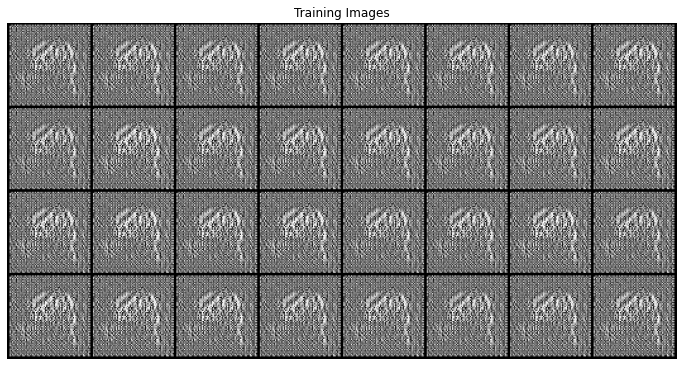

Epoch 19: 99%
 - Generator loss: 11.637343406677246, Discriminator loss: 0.08052831143140793


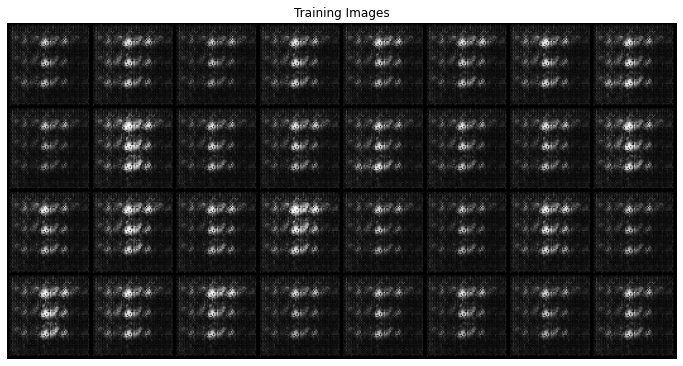

Epoch 20: 99%
 - Generator loss: 12.773290634155273, Discriminator loss: 0.061389584094285965


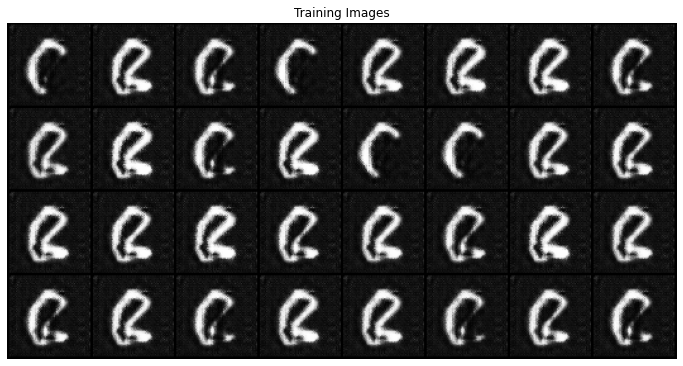

In [ ]:
# Initiate Discriminator and Discriminator
generator = Generator(ls_size, fm_size, num_img_chan, num_layers)
discriminator = Discriminator(fm_size, num_img_chan, num_layers)

# Initiate Generative Adverserial Network
gan = Gan(generator, discriminator, dataloader, batch_size, ls_size)
gan.train()